# Desafío 2: Rendimiento Escolar
### Team DodgerBlue: Francisco Letelier - Matias Rojas

# HITO 1
## Preliminares

## Descripción del problema

Lo contactan de una escuela Portuguesa para generar un modelo que identifique aquellos alumnos que presentan un bajo desempeño académico, medido en el promedio final del año escolar. Para ello le envían un archivo con registros sociodemográficos y conductuales de los alumnos dos escuelas para <b>perfilar</b> a los estudiantes.

De manera adicional la psicopedagoga sugiere inspeccionar una batería de preguntas asociadas a aspectos ambientales del alumno (de famrel a health) y ver si éstas se pueden abstraer encategorías latentes.

Para desarrollar este problema se utilizará un modelo de regresión, el cual permitirá determinar que variables son relevantes para nuestro vector objetivo (variable dependiente), a su vez se generará un modelo de clasificación para obtener información respecto a la batería de preguntas realizadas al alumno.

para medir la eficacia del modelo de regresión utilizaremos los siguientes metodos y valores: <br><br>
* Test de hipótesis nula
* Nivel de significancia (al 95%)
* p-value
* coeficiente de correlación
* $R^{2}$

Para la dimensionalidad, aplicable a nuestro set de preguntas, y medir la eficiencia de los factores utilizaremos las siguientes métricas:

* Esferacidad de Bartlett
* Prueba de Kaiser-Meyer-Olkin (KMO)


En el caso de KMO para poder eliminar del set de datos los factores no considerados latentes. 
* Valores mayores a 0.7 -> Considera que existe al menos un factor latente. 
* Valores menores a 0.7 -> Considera que no existen factores latentes.

 


# HITO 2
## Aspectos computacionales

Para el desarrollo de este modelo predictivo se utilizarán las siguientes librerias, las cuales se detallan a continuación:

`pandas`, `numpy`: manejo de datos (df) y transformación de los mismos.

`matplotlib`, `seaborn`: para generar visualizaciones de datos

`sklearn`: libreria de _machine learning_ para aplicar el modelo

`IPython.display` , `tabulate`: Generar prints con mejor aspecto

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import missingno as msno
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from funciones_desafio2 import transformaciones
from funciones_desafio2 import modelo_descriptivo
from funciones_desafio2 import quest_batery
import factor_analyzer as factor
from funciones_desafio2 import coefplot
import factor_analyzer as factor
from IPython.display import HTML, display
import tabulate

Se importa el dataset y se visualizan las primeras columnas:

In [2]:
df = pd.read_csv('students.csv', delimiter="|").drop('Unnamed: 0', axis=1)
df.head()
tmp = df

In [3]:
columnas = df.columns.to_list()
for columna in columnas:
    print(df[columna].value_counts())

GP              345
MS               45
zero              2
sem validade      2
nulidade          1
Name: school, dtype: int64
F               206
M               186
sem validade      1
nulidade          1
zero              1
Name: sex, dtype: int64
"16"            101
"17"             98
"15"             82
"18"             81
"19"             24
"20"              3
nulidade          3
"21"              1
sem validade      1
"22"              1
Name: age, dtype: int64
U               305
R                88
sem validade      2
Name: address, dtype: int64
GT3             278
LE3             113
zero              2
sem validade      2
Name: famsize, dtype: int64
T               349
A                40
sem validade      4
nulidade          1
zero              1
Name: Pstatus, dtype: int64
4               129
2               103
3                98
1                59
0                 3
sem validade      2
nulidade          1
Name: Medu, dtype: int64
2               112
3               

## Descripción

se realiza la transformación de la variable `?` a `NA` para su posterior tratamiento y se realiza una primera inspección de la data

In [4]:
df = df.replace(to_replace ="?",value = np.nan)

In [5]:
df = df.replace(to_replace = ["nulidade",
                              "sem validade",
                              "zero"],value = np.nan)

In [6]:
#Distribución de valores nulos por columna
df.isnull().sum(axis = 0)

school        5
sex           3
age           4
address       2
famsize       4
Pstatus       6
Medu          3
Fedu          5
Mjob          6
Fjob          0
reason        4
guardian      4
traveltime    3
studytime     5
failures      5
schoolsup     8
famsup        5
paid          1
activities    5
nursery       6
higher        6
internet      3
romantic      2
famrel        5
freetime      2
goout         5
Dalc          3
Walc          5
health        4
absences      4
G1            4
G2            0
G3            3
dtype: int64

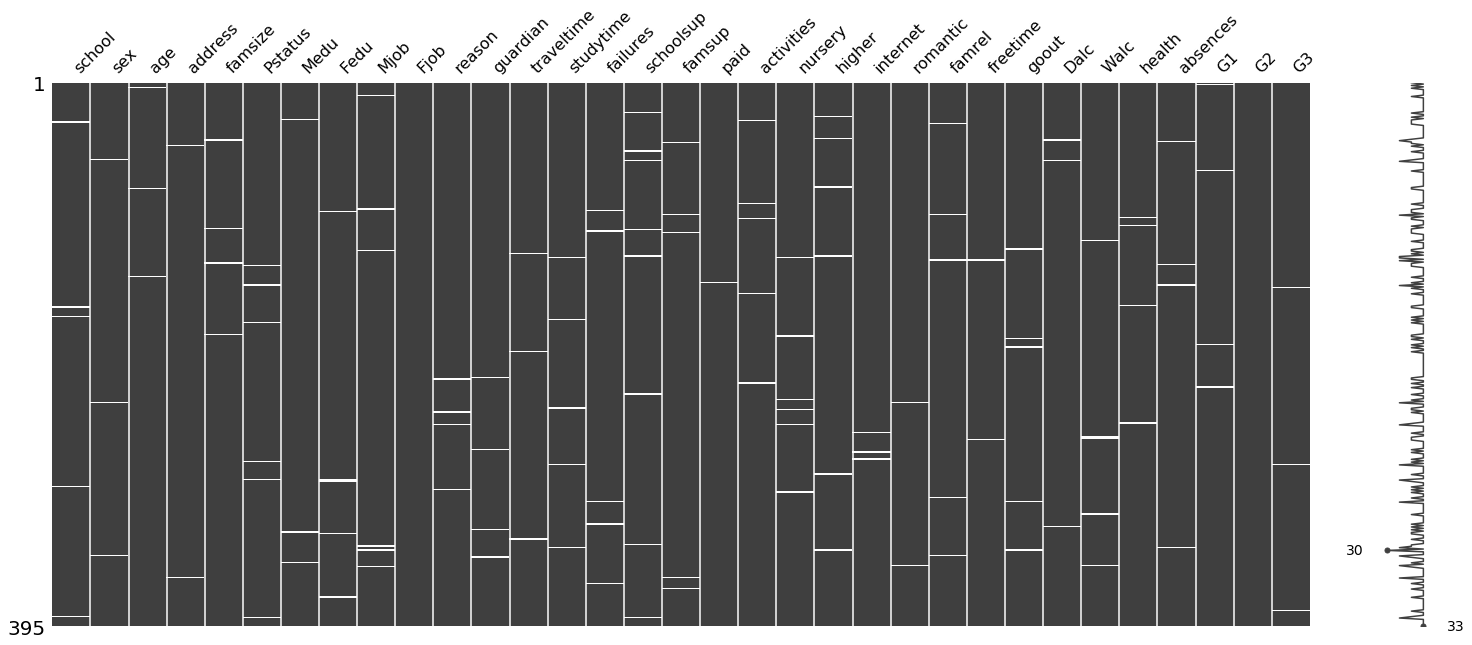

In [7]:
msno.matrix(df)

analisis de las variables perdidas, existen 3 variables que presentan dichas variables:
workclass, occupation, native_country

se eliminan los valores perdidos

In [8]:
#drop na
df = df.dropna()

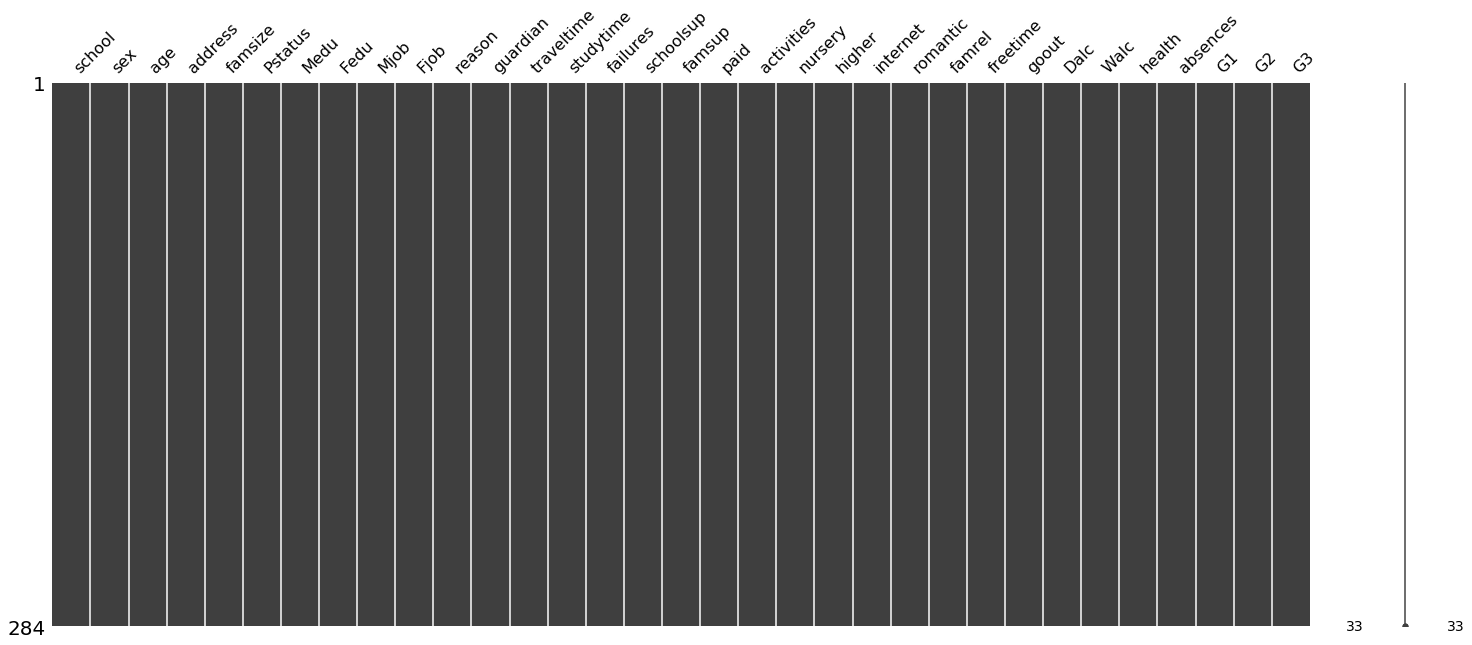

In [9]:
# analizar luego del dropna()
msno.matrix(df)

## Transformaciones
se examinan los tipos de datos del dataframe

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284 entries, 1 to 394
Data columns (total 33 columns):
school        284 non-null object
sex           284 non-null object
age           284 non-null object
address       284 non-null object
famsize       284 non-null object
Pstatus       284 non-null object
Medu          284 non-null object
Fedu          284 non-null object
Mjob          284 non-null object
Fjob          284 non-null object
reason        284 non-null object
guardian      284 non-null object
traveltime    284 non-null object
studytime     284 non-null object
failures      284 non-null object
schoolsup     284 non-null object
famsup        284 non-null object
paid          284 non-null object
activities    284 non-null object
nursery       284 non-null object
higher        284 non-null object
internet      284 non-null object
romantic      284 non-null object
famrel        284 non-null object
freetime      284 non-null object
goout         284 non-null object
Dalc       

para realiar el cambio de tipo de datos es necesario determinar en primera instancia que tipo de datos tiene cada columna, para posteriormente cambiar los datos que correspondan.

In [11]:
columnas = df.columns.to_list()
for columna in columnas:
    print(columna + ' ' + str(df[columna].dtypes) )

school object
sex object
age object
address object
famsize object
Pstatus object
Medu object
Fedu object
Mjob object
Fjob object
reason object
guardian object
traveltime object
studytime object
failures object
schoolsup object
famsup object
paid object
activities object
nursery object
higher object
internet object
romantic object
famrel object
freetime object
goout object
Dalc object
Walc object
health object
absences object
G1 object
G2 int64
G3 object


se definen que columnas serán númericas y se realiza el cambio de metadata, adicionalmente se elimina la doble comilla existente en alguno de ellos

In [12]:
columnas = ['age','Medu','Fedu','traveltime','studytime','failures','famrel','freetime','goout','Dalc','Walc',
            'health','absences','G1','G2','G3']
for columna in columnas:
    print(columna +  u' \u2713')
    df[columna]=df[columna].astype(str).str.replace('"', '')
    df[columna] = pd.to_numeric(df[columna])

age ✓
Medu ✓
Fedu ✓
traveltime ✓
studytime ✓
failures ✓
famrel ✓
freetime ✓
goout ✓
Dalc ✓
Walc ✓
health ✓
absences ✓
G1 ✓
G2 ✓
G3 ✓


In [13]:
# se almacena el DF transformado para ser utilizado posteriormente
tmp = df

una vez corregidos los tipos de datos se crea una función que binarizará las columnas del dataframe

In [14]:
df = transformaciones(df, ['G1','G2','G3'])

In [15]:
columnas = df.columns.to_list()
for columna in columnas:
    print(df[columna].value_counts())

10    38
8     33
12    29
13    25
9     24
7     23
11    22
14    21
6     17
15    16
16    15
17     8
18     5
5      5
19     2
4      1
Name: G1, dtype: int64
9     38
10    34
12    32
13    25
11    23
8     22
15    20
7     17
14    16
6     11
16    11
0     10
5      9
18     7
17     5
19     3
4      1
Name: G2, dtype: int64
10    40
11    32
0     26
12    24
13    22
9     21
8     21
15    20
14    20
6     13
16    11
7      9
18     7
17     6
19     5
5      5
4      1
20     1
Name: G3, dtype: int64
0    247
1     37
Name: bin_school_MS, dtype: int64
0    147
1    137
Name: bin_sex_M, dtype: int64
0    214
1     70
Name: bin_age_18, dtype: int64
0    223
1     61
Name: bin_age_15, dtype: int64
0    224
1     60
Name: bin_age_17, dtype: int64
0    269
1     15
Name: bin_age_19, dtype: int64
0    281
1      3
Name: bin_age_20, dtype: int64
0    283
1      1
Name: bin_age_21, dtype: int64
0    214
1     70
Name: bin_address_R, dtype: int64
0    209
1     75
Name: bi

se revisa el dataframe binarizado, validando la eliminación de las columnas que fueron transformadas

In [16]:
df.head()

,G1,G2,G3,bin_school_MS,bin_sex_M,bin_age_18,bin_age_15,bin_age_17,bin_age_19,bin_age_20,...,bin_absences_21,bin_absences_22,bin_absences_24,bin_absences_25,bin_absences_26,bin_absences_28,bin_absences_30,bin_absences_38,bin_absences_40,bin_absences_75
1,5,5,6,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,14,15,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,15,15,15,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,12,12,11,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,6,5,6,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Hito 3
### MODELO DESCRIPTIVO

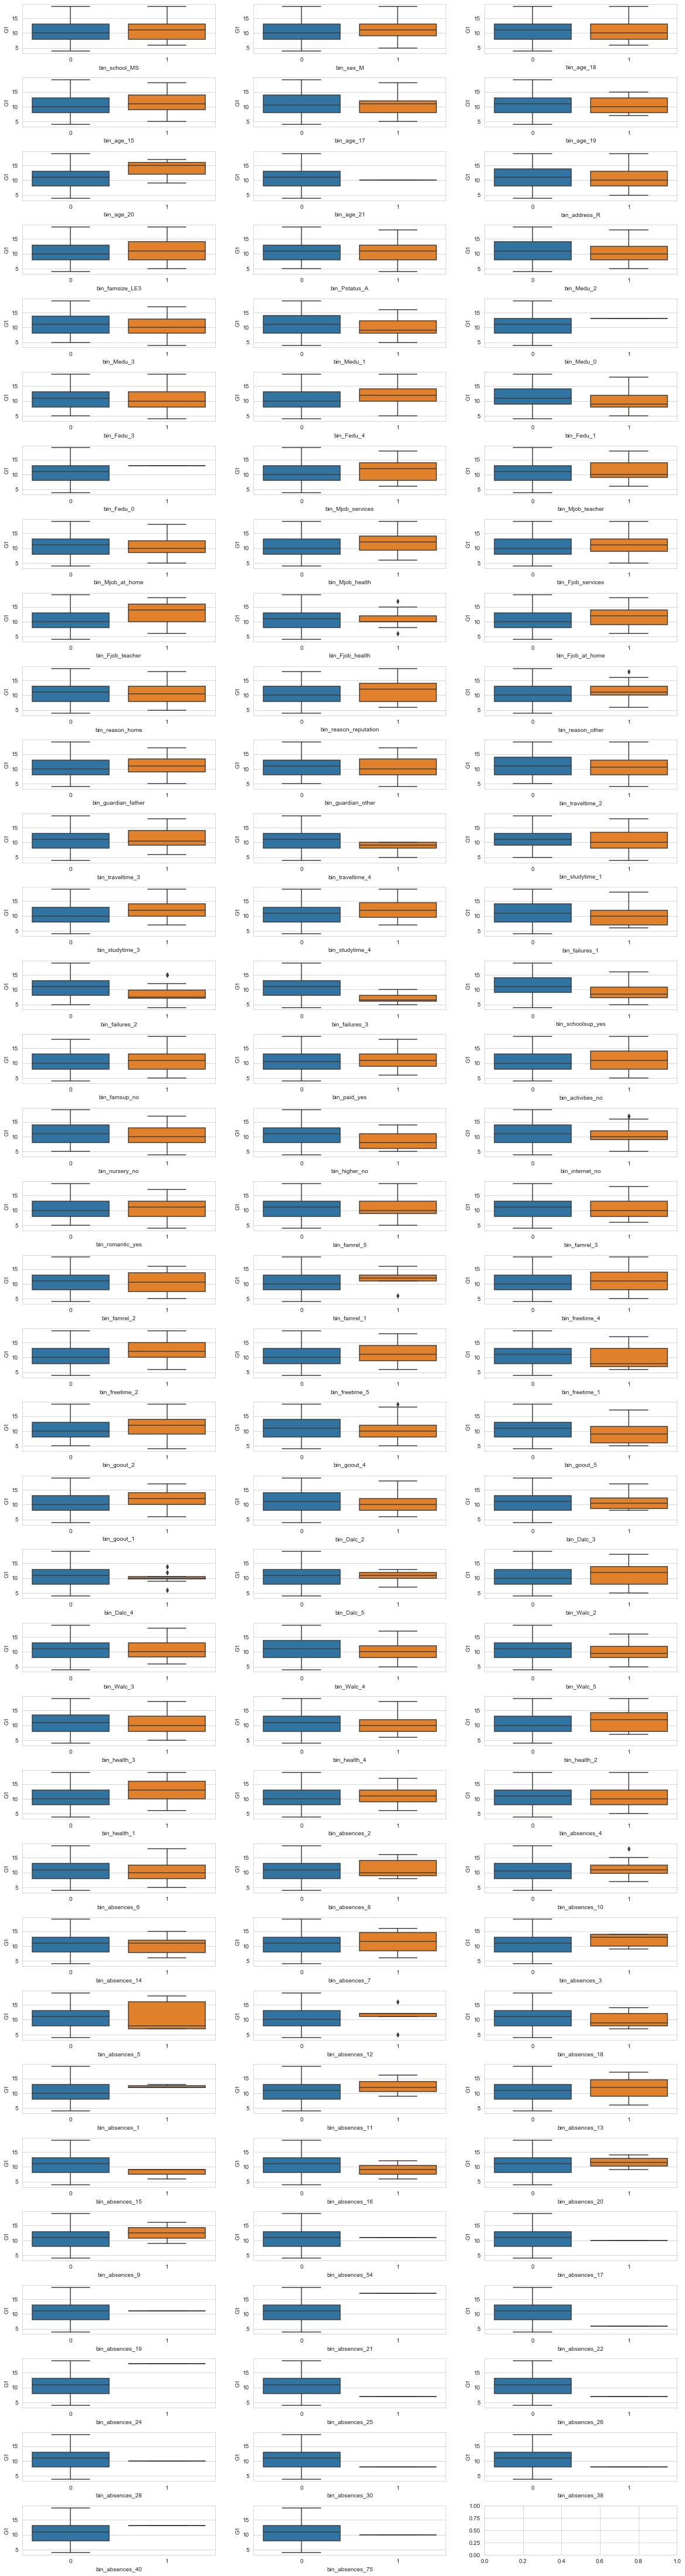

In [17]:
modelo_descriptivo(df, ['G1','G2','G3'], 'G1')

## Interpretación[G1]
* school: estudiantes del colegio Mousinho da Silveira presentan levemente un mejor desempeño que el colegio Garbiel Pereira
* sex: Apesar de que en los colegios existen mayor cantidad de Hombres, las mujeres presentan levemente un mejor desempeño en sus notas del primer semestre.
* age: en promedio un estudiante presenta un mejor desempeño en su promedio del primer semestre cuando este tiene alrededor de 20 años.
* address:  los alumnos que que viven en zonas urbanas presentan mejor desempeño en comparación a los alumnos que viven en zons rurales.
* famsize: alumnos con familias de más de 3 integrantes presentan un mejor desempeño.
* Pstatus: el factor cohabitacional de los padres no tiene una implicancia notoria en el desempeño del alumno.
* Medu: a mayor nivel educacional de la madre, mejor es el desempeño del alumno.
* Fedu: en los casos donde el padre estudia de 5-9 o en la educación superior, impacta sobre el desempeño del alumno.
* Mjob: Ocupación de la madre en los casos en que la madre trabaje en servicios, profesora, salud u otro, los alumnos presentan un mejor desempeño en comparación a cuando la madre trabaja en casa.
* fjob: Ocupación del padre, para cuando el padre trabaja como profesor, el alumno presenta un mejor desempeo en comparación al resto de profesiones de categorias, seguido por  trabaja en casa, servicios y finalmente en salud.
* reason: Razón para escoger la escuela, los alumnos presentan un mejor desempeño cuando escojen la escuela por motvos de reputación y preferencia de cursos.
* guardian Padre: Apoderado del estudiante, cuando el apoderado es el padre el desempeño del estudiante no presenta grandes variaciones.
* gaurdian otro: cuando el apoderado no es ni el padre ni la madre el desempeño baja levemente en comparación a cuando el apoderado es el padre.
* traveltime: Tiempo de viaje entre hogar y colegio, para cuando el estudiante v de 1 hora, este presentara malos resultados en su desempeño academico.
* studytime: Horas semanales dedicadas al estudio, alumnos que dediquen 10 horas de estudio presentan en promedio un mejor desempeño.
* failures: Número de clases reprobadas, El numero de clases reprobadas tiene una relación directamente proporcional sobre el promedio, a mayor cantidad de clases repetidas, menor será el promedio.
* schoolsup: Apoyo educacional del colegio, alumnos que cuentan con apoyo educacional presentan un mejor desempeño que los alumnos que si cuentan con apoyo
* famsup: Apoyo educacional familiar, llama la atención que el apoyo educacional no representa una gran diferencia entre alumnos que lo reciben y los que no.
* paid: Clases particulares pagadas, alumnos que tuvieron la oportunidad de tener clases pagadas presentan levemente un mejor desempeño.
* activities: Actividades extracurriculares, alumnos que no tienen actividades extracurriculares presentan un mejor desempeño.
* nursery: Asistió a guardería infantil, los alumnos que no asistieron a una guarderia presentan un menor desempeño
* higher: Desea proseguir estudios superiores, los alumnos que si desean continuar con educación superior presentan un mayor desempeño.
* internet: Acceso a internet desde el hogar, quienes no tienen acceso presentan un menor desempeño.
* romantic: Relación romántica, alumnos que tienen una relación romantica presentan un mejor desempeño.
* famrel: Calidad de las relaciones familiares, llama la atención que la cantidad de alumnos que presentan una mala relación familiar es muy baja, sin embargo en terminos de desempeño están por encima del resto.
* freetime: Tiempo libre fuera del colegio, alumnos con poca cantidad de tiempo libre presentan un peor desempeño.
* goout: Salidas con amigos, Mientras menos salidas con amigos existan, el estudiante presentara un mejor desempeño academico.
* Dalc: Consumo de alcohol en día de semana , Mientras menor alcohol durante la semana, mejor sera el desempeño academico del estudiante.
* Walc: Consumo de alcohol en fines de semana, a mayor consumo menor será el desempeño de estudiante.
* health: Estado de salud actual alumnos con malos estados de salud extrañamente presentan un mejor rendimiento, mientras aquellos alumnos que no tienen un mal estado de salud su desempeño no se ve afectado.
* absences: estudiantes que tengan 5 o 15 ausencias presentarán un cambio en su desempeño de manera significativa. 

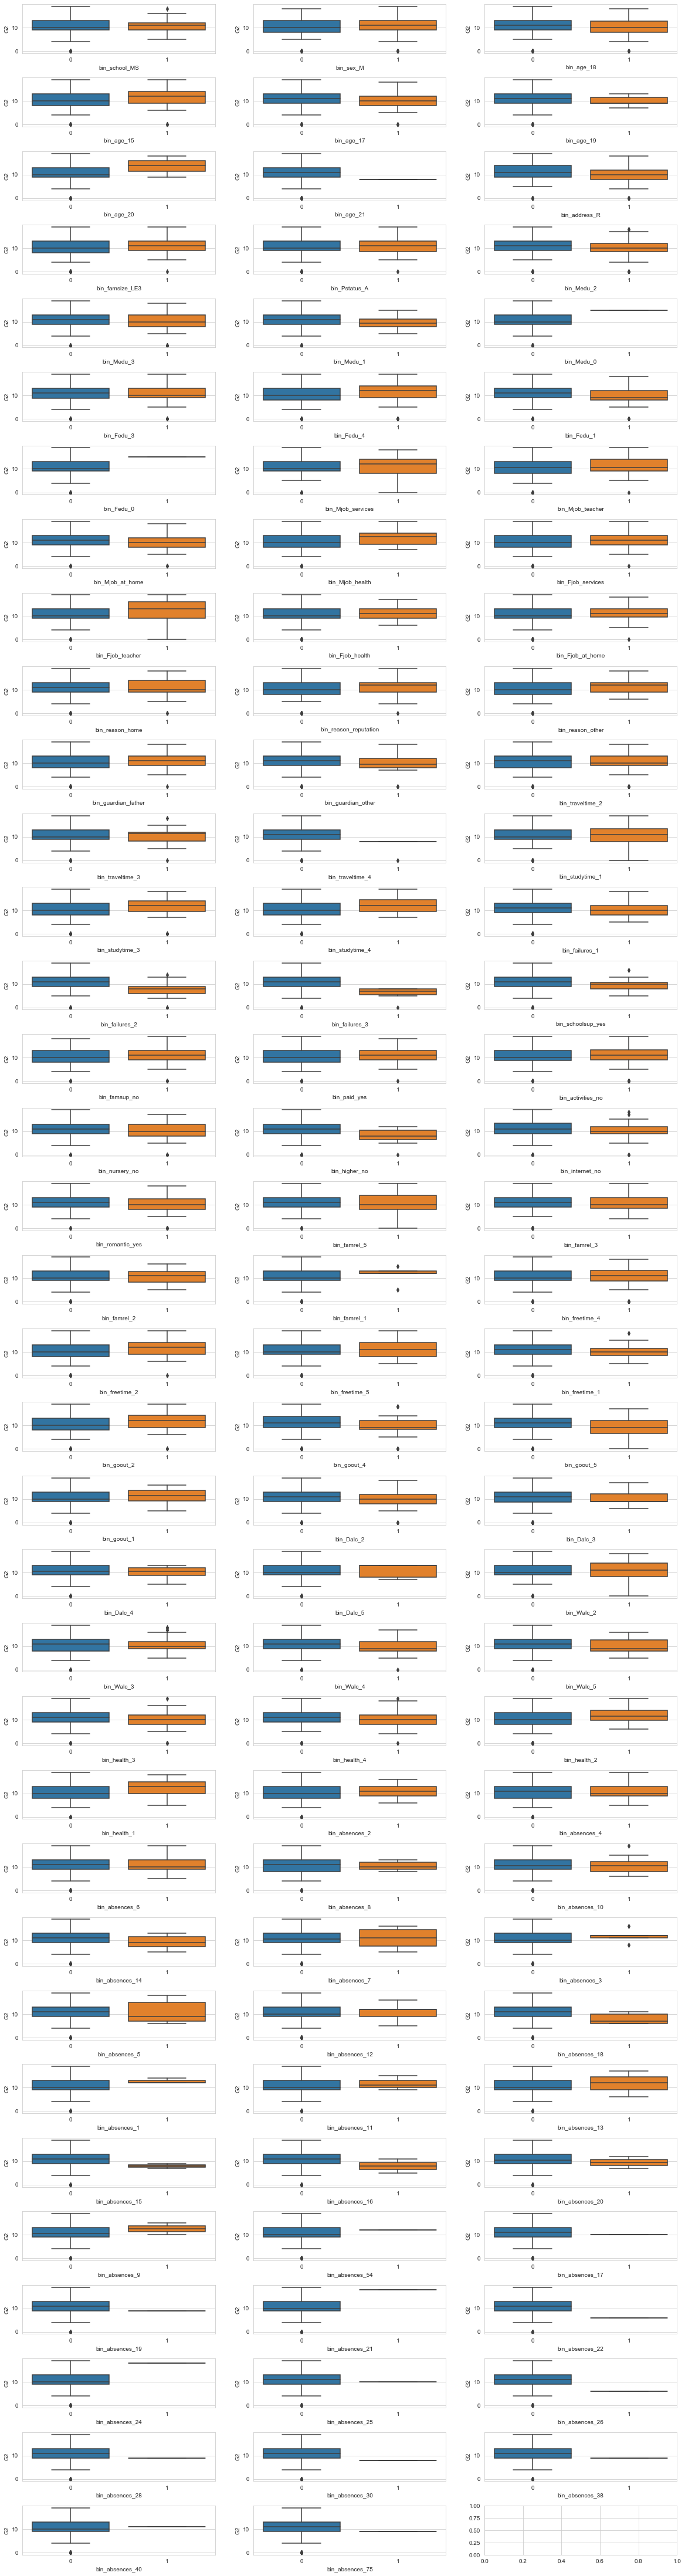

In [18]:
modelo_descriptivo(df, ['G1','G2','G3'], 'G2')

## Interpretación[G2]
* school: estudiantes del colegio Mousinho da Silveira presentan levemente un mejor desempeño que el colegio Garbiel Pereira
* sex: Apesar de que en los colegios existen mayor cantidad de Hombres, las mujeres presentan levemente un mejor desempeño en sus notas del primer semestre.
* age: alumnos de 15 y 20 años presentan un mejor desempeño.
* address:  los alumnos que que viven en zonas urbanas presentan mejor desempeño en comparación a los alumnos que viven en zons rurales.
* famsize: alumnos con familias de más de 3 integrantes presentan un mejor desempeño.
* Pstatus: alumnos donde sus padres viven separados presentan levemente un mejor desempeño.
* Medu: a diferencia de G1, el nivel educacional de la madre no impacta significativamente el desempeño del alumno.
* Fedu: en los casos donde el nivel educacional del padre es de educación superior se traduce en una leve mejora en el desempeño del alumno.
* Mjob: Ocupación de la madre en los casos en que la madre trabaja en servicios y salud los alumnos presentan un mejor desempeño.
* fjob: Ocupación del padre, para cuando el padre trabaja como profesor, el alumno presenta un mejor desempeño.
* reason: Razón para escoger la escuela, los alumnos presentan un mejor desempeño cuando escojen la escuela por motvos de reputación.
* guardian Padre: Apoderado del estudiante, cuando el apoderado es el padre el desempeño del estudiante no presenta grandes variaciones.
* traveltime: Tiempo de viaje entre hogar y colegio, para cuando el estudiante viaja de 1 hora, este presentara malos resultados en su desempeño academico.
* studytime: Horas semanales dedicadas al estudio, alumnos que mayor cantidad denhoras de estudio presentan en promedio un mejor desempeño.
* failures: Número de clases reprobadas, El numero de clases reprobadas tiene una relación directamente proporcional sobre el promedio, a mayor cantidad de clases repetidas, menor será el promedio.
* schoolsup: Apoyo educacional del colegio, alumnos que cuentan con apoyo educacional presentan un menor desempeño que los alumnos que no cuentan con apoyo.
* famsup: Apoyo educacional familiar, llama la atención que el apoyo educacional representa una leve mejoria en alumnos que no lo reciben.
* paid: Clases particulares pagadas, alumnos que tuvieron la oportunidad de tener clases pagadas presentan levemente un mejor desempeño.
* activities: Actividades extracurriculares, alumnos que no tienen actividades extracurriculares presentan un mejor desempeño.
* nursery: Asistió a guardería infantil, los alumnos que no asistieron a una guarderia presentan un menor desempeño
* higher: Desea proseguir estudios superiores, los alumnos que si desean continuar con educación superior presentan un mayor desempeño.
* internet: Acceso a internet desde el hogar, quienes no tienen acceso presentan un menor desempeño.
* romantic: Relación romántica, alumnos que tienen una relación romantica presentan levemente un menor desempeño.
* famrel: Calidad de las relaciones familiares, llama la atención que la cantidad de alumnos que presentan una mala relación familiar es muy baja, sin embargo en terminos de desempeño están por encima del resto.
* freetime: Tiempo libre fuera del colegio, en términos de promedio el tiempo libre no representa grandes diferencias.
* goout: Salidas con amigos, Mientras menos salidas con amigos existan, el estudiante presentara un mejor desempeño academico.
* Dalc: Consumo de alcohol en día de semana , Mientras menor alcohol durante la semana, mejor sera el desempeño academico del estudiante.
* Walc: Consumo de alcohol en fines de semana, a mayor consumo menor será el desempeño de estudiante.
* health: Estado de salud actual alumnos con malos estados de salud extrañamente presentan un mejor rendimiento, mientras aquellos alumnos que no tienen un mal estado de salud su desempeño no se ve afectado.

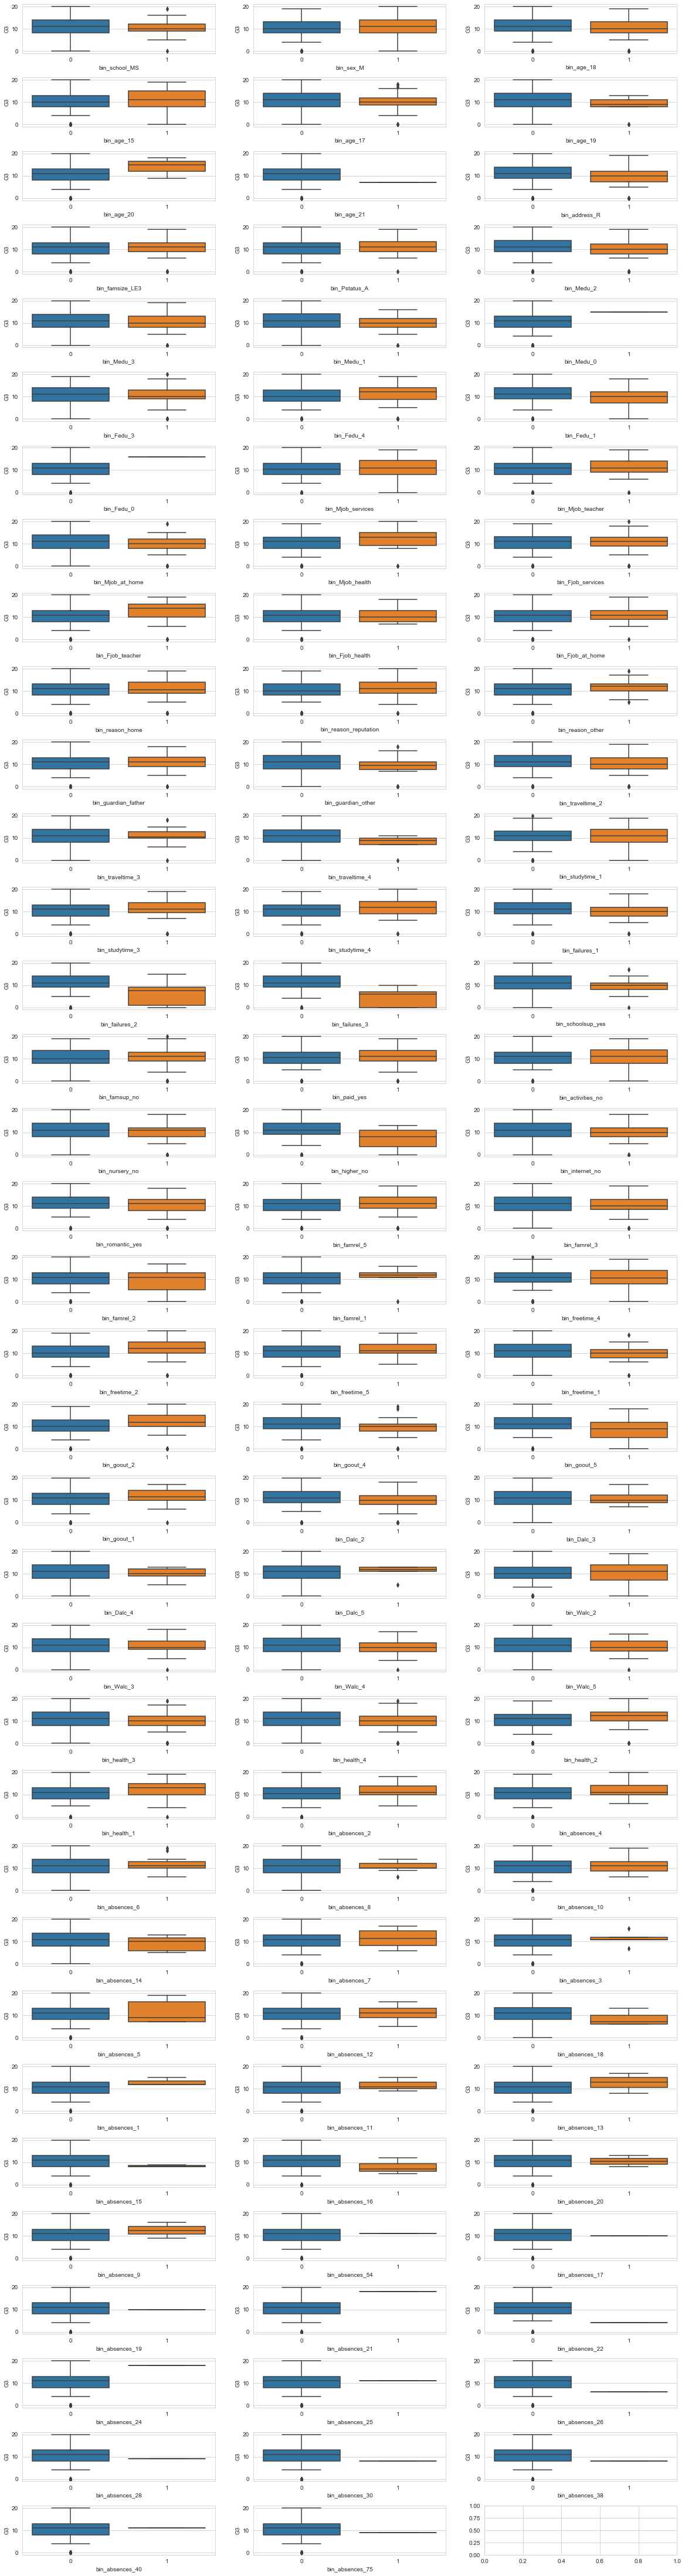

In [19]:
modelo_descriptivo(df, ['G1','G2','G3'], 'G3')

## Interpretación[G3]
* school: estudiantes del colegio Mousinho da Silveira presentan levemente un menor desempeño que el colegio Garbiel Pereira con respecto a su promedio final
* sex: Apesar de que en los colegios existen mayor cantidad de Hombres, los hombres presentar un mejor desempeño con respecto a su promedio final.
* age: alumnos con 20 años presentan un mejor desempeño.
* address:  los alumnos que que viven en zonas urbanas presentan mejor desempeño en comparación a los alumnos que viven en zons rurales.
* famsize: con respecto al promedio final la cantidad de integrantes no presenta variación en términos de desempeño.
* Pstatus: alumnos donde sus padres viven separados no presenta una variación en su desempeño.
* Medu: el nivel educacional de la madre no impacta en el desempeño del alumno referente a su promedio final.
* Fedu: en los casos donde el nivel educacional del padre es de educación superior se traduce en una leve mejora en el desempeño del alumno.
* Mjob: Ocupación de la madre en los casos en que la madre trabaja en salud los alumnos presentan un mejor desempeño.
* fjob: Ocupación del padre, para cuando el padre trabaja como profesor, el alumno presenta un mejor desempeño.
* reason: Razón para escoger la escuela, los alumnos presentan un mejor desempeño cuando escojen la escuela por motvos de reputación u otro.
* guardian Padre: Apoderado del estudiante, cuando el apoderado es el padre el desempeño del estudiante presenta una leve mejoria.
* traveltime: Tiempo de viaje entre hogar y colegio, para cuando el estudiante viaja más de 1 hora, este presentara una leve disminución en su desempeño academico.
* studytime: Horas semanales dedicadas al estudio, alumnos que mayor cantidad de horas de estudio presentan en promedio un mejor desempeño.
* failures: Número de clases reprobadas, El numero de clases reprobadas tiene una relación directamente proporcional sobre el promedio, a mayor cantidad de clases repetidas, menor será el promedio.
* schoolsup: Apoyo educacional del colegio, alumnos que cuentan con apoyo educacional presentan un menor desempeño que los alumnos que no cuentan con apoyo.
* famsup: Apoyo educacional familiar, llama la atención que el apoyo educacional representa una leve mejoria en alumnos que no lo reciben.
* paid: Clases particulares pagadas, alumnos que tuvieron la oportunidad de tener clases pagadas presentan levemente un mejor desempeño.
* activities: Actividades extracurriculares, no representa una variación en términos de promedio en alumnos que tienen actividades vs lo que no tienen actividades
* nursery: Asistió a guardería infantil, no representa una variación en términos de promedio en alumnos que asistieron a guarderia vs los que no.
* higher: Desea proseguir estudios superiores, alumnos que no desean continuar con estudios superiores presentan un menor desempeño.
* internet: Acceso a internet desde el hogar, quienes no tienen acceso presentan levemente un menor desempeño.
* romantic: Relación romántica, no representa una variación en el desempeño.
* famrel: Calidad de las relaciones familiares, a diferencia de G1, G2 para el caso de G3 aquellos alumnos que tenian una mala relación familiar no presentan mayores variaciones de desempeño con respecto al resto.
* freetime: Tiempo libre fuera del colegio, alumnos con poco tiempo libre (2), presentan un mejor desempeño.
* goout: Salidas con amigos, Mientras menos salidas con amigos existan, el estudiante presentara un mejor desempeño academico.
* Dalc: Consumo de alcohol en día de semana , apesar de ser pocos, los alumnos que consumen mayor alcohol en la semana presentan un mayor desempeño.
* Walc: Consumo de alcohol en fines de semana, alumnos que consumen poco alcohol los fines de semana presentan un levemente un mejor desempeño.
* health: Estado de salud actual alumnos con malos estados de salud extrañamente presentan un mejor desempeño.

## Modelo Predictivo [G3]

In [20]:
df

,G1,G2,G3,bin_school_MS,bin_sex_M,bin_age_18,bin_age_15,bin_age_17,bin_age_19,bin_age_20,...,bin_absences_21,bin_absences_22,bin_absences_24,bin_absences_25,bin_absences_26,bin_absences_28,bin_absences_30,bin_absences_38,bin_absences_40,bin_absences_75
1,5,5,6,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,14,15,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,15,15,15,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,12,12,11,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,6,5,6,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,16,18,19,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,14,15,15,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,10,12,12,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,14,14,14,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,10,10,11,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
columnas = df.columns.to_list()
tmpcolumns = 'G3 ~ '
for columna in columnas:
    if columna  not in ['G3','G2','G1']:
        tmpcolumns += ' + '+ columna
tmpcolumns
model1G3 = smf.ols(tmpcolumns, df)
model1G3 = model1G3.fit()
model1G3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     1.896
Date:                Thu, 14 Nov 2019   Prob (F-statistic):           8.72e-05
Time:                        12:17:08   Log-Likelihood:                -728.29
No. Observations:                 284   AIC:                             1667.
Df Residuals:                     179   BIC:                             2050.
Df Model:                         104                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.3361      1.656      5.034      0.000       5.068      11.604
bin_school_MS             1.0858      1.079      1.006      0.316      -1.044       3.216
bin_sex_M                 0.5871      0.680      0.863      0.389      -0.755       1.929
bin_age_18               -1.7215      0.908     -1.895      0.060      -3.514       0.071
bin_age_15               -1.3456      0.833     -1.615      0.108      -2.990       0.299
bin_age_17               -0.9965      0.841     -1.185      0.238      -2.656       0.663
bin_age_19               -0.1436      1.989     -0.072      0.943      -4.068       3.781
bin_age_20                3.8398      3.561      1.078      0.282      -3.187      10.867
bin_age_21               -2.7547      5.832     -0.472      0.637     -14.263       8.754
bin_address_R            -0.5676      0.804     -0.706      0.481      -2.154       1.019
bin_famsize_LE3           0.4033      0.700      0.576      0.565      -0.978       1.784
bin_Pstatus_A             1.5239      1.116      1.366      0.174      -0.678       3.726
bin_Medu_2               -2.0862      1.130     -1.847      0.066      -4.316       0.143
bin_Medu_3               -1.1315      1.029     -1.100      0.273      -3.162       0.899
bin_Medu_1               -1.7833      1.455     -1.226      0.222      -4.655       1.088
bin_Medu_0                0.4053      4.575      0.089      0.930      -8.623       9.434
bin_Fedu_3               -0.6154      0.824     -0.747      0.456      -2.241       1.011
bin_Fedu_4                0.0671      1.019      0.066      0.948      -1.943       2.078
bin_Fedu_1                0.0964      0.923      0.104      0.917      -1.724       1.917
bin_Fedu_0                3.7983      4.504      0.843      0.400      -5.090      12.686
bin_Mjob_services         0.0136      0.803      0.017      0.986      -1.571       1.598
bin_Mjob_teacher         -1.2573      1.201     -1.047      0.296      -3.627       1.112
bin_Mjob_at_home          0.0290      0.925      0.031      0.975      -1.797       1.855
bin_Mjob_health           0.0165      1.263      0.013      0.990      -2.475       2.508
bin_Fjob_services         0.7308      0.749      0.976      0.330      -0.747       2.208
bin_Fjob_teacher          0.9945      1.267      0.785      0.434      -1.506       3.495
bin_Fjob_health          -0.0009      1.456     -0.001      1.000      -2.874       2.872
bin_Fjob_at_home          0.3830      1.539      0.249      0.804      -2.653       3.419
bin_reason_home           0.9027      0.763      1.184      0.238      -0.602       2.408
bin_reason_reputation     1.5951      0.766      2.082      0.039       0.084       3.107
bin_reason_other          0.8767      1.038      0.845      0.399      -1.171       2.924
bin_guardian_father    

In [22]:
model1G3.pvalues[model1G3.pvalues<=0.05]

Intercept                0.000001
bin_reason_reputation    0.038721
bin_failures_3           0.013352
bin_famsup_no            0.013738
bin_activities_no        0.024104
bin_freetime_5           0.007346
bin_goout_2              0.036979
bin_goout_5              0.047813
bin_goout_1              0.015057
bin_Dalc_4               0.041282
bin_Walc_5               0.003011
bin_absences_2           0.000627
bin_absences_4           0.028471
bin_absences_6           0.030486
dtype: float64

#### Con una significancia del 99% se eliminan del modelo atributos cuyo valor $p$ sea  mayor a 0.05.
se conservan los siguientes features considerando como vector objetivo G3:
* bin_reason_reputation
* bin_failures_3
* bim_famsup_no
* bin_activities_no
* bin_freetime_5
* bin_goout_2
* bin_goout_5
* bin_goout_1
* bin_dalc_4
* bin_walc_5
* bin_absences_2
* bin_absences_4
* bin_absences_6

In [23]:
varmodelo = model1G3.pvalues[model1G3.pvalues<=0.05].index
modelsintax='G3 ~'
for var in varmodelo:
    if var != 'Intercept':
        modelsintax += var + '+'
modelsintax=modelsintax[:-1]
modelsintax

'G3 ~bin_reason_reputation+bin_failures_3+bin_famsup_no+bin_activities_no+bin_freetime_5+bin_goout_2+bin_goout_5+bin_goout_1+bin_Dalc_4+bin_Walc_5+bin_absences_2+bin_absences_4+bin_absences_6'

In [24]:
model2G3 = smf.ols(modelsintax, df)
model2G3 = model2G3.fit()
model2G3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     4.006
Date:                Thu, 14 Nov 2019   Prob (F-statistic):           5.23e-06
Time:                        12:17:08   Log-Likelihood:                -808.72
No. Observations:                 284   AIC:                             1645.
Df Residuals:                     270   BIC:                             1697.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.4157      0.589     14.283      0.000       7.256       9.576
bin_reason_reputation     1.0917      0.594      1.839      0.067      -0.077       2.260
bin_failures_3           -5.1400      1.467     -3.503      0.001      -8.029      -2.251
bin_famsup_no             0.7959      0.531      1.498      0.135      -0.250       1.842
bin_activities_no         0.8489      0.518      1.637      0.103      -0.172       1.870
bin_freetime_5            2.8364      0.901      3.149      0.002       1.063       4.610
bin_goout_2               1.1775      0.606      1.943      0.053      -0.016       2.370
bin_goout_5              -2.1503      0.893     -2.407      0.017      -3.909      -0.391
bin_goout_1               1.2096      1.220      0.992      0.322      -1.191       3.611
bin_Dalc_4               -0.8145      1.600     -0.509      0.611      -3.965       2.336
bin_Walc_5                1.4436      1.139      1.267      0.206      -0.799       3.686
bin_absences_2            1.8802      0.698      2.693      0.008       0.506       3.255
bin_absences_4            1.5214      0.760      2.002      0.046       0.025       3.018
bin_absences_6            1.6087      0.968      1.662      0.098      -0.297       3.515
==============================================================================
Omnibus:                        7.419   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                7.349
Skew:                          -0.390   Prob(JB):                       0.0254
Kurtosis:                       3.107   Cond. No.                         8.54
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Con una significancia del 99% se eliminan del modelo atributos cuyo valor $p$ sea  mayor a 0.05.

se conservan los siguientes features considerando como vector objetivo G3:
* bin_failures_3
+ bin_freetime_5
+ bin_goout_5
+ bin_absences_2
+ bin_absences_4

In [25]:
varmodelo = model2G3.pvalues[model2G3.pvalues<=0.05].index
modelsintax='G3 ~'
for var in varmodelo:
    if var != 'Intercept':
        modelsintax += var + '+'
modelsintax=modelsintax[:-1]
modelsintax

'G3 ~bin_failures_3+bin_freetime_5+bin_goout_5+bin_absences_2+bin_absences_4'

In [26]:
model3G3 = smf.ols(modelsintax, df)
model3G3 = model3G3.fit()
model3G3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     7.281
Date:                Thu, 14 Nov 2019   Prob (F-statistic):           1.99e-06
Time:                        12:17:08   Log-Likelihood:                -816.29
No. Observations:                 284   AIC:                             1645.
Df Residuals:                     278   BIC:                             1666.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.1636      0.337     30.134      0.000       9.500      10.828
bin_failures_3    -5.1804      1.460     -3.548      0.000      -8.055      -2.306
bin_freetime_5     2.7428      0.893      3.071      0.002       0.985       4.501
bin_goout_5       -2.2517      0.848     -2.656      0.008      -3.921      -0.583
bin_absences_2     1.4504      0.691      2.099      0.037       0.090       2.811
bin_absences_4     1.0753      0.749      1.437      0.152      -0.398       2.549
==============================================================================
Omnibus:                       11.895   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.181
Skew:                          -0.487   Prob(JB):                      0.00226
Kurtosis:                       3.282   Cond. No.                         6.03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Predicción de notas para G3, utilizando todos los atributos del set de datos

In [27]:
x = df.drop(columns = ['G3','G2','G1'], axis = 1)
y = df["G3"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .33, random_state = 42)

In [28]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(190, 104)
(94, 104)
(190,)
(94,)


In [29]:
model1ml = LinearRegression(fit_intercept = True, normalize = True).fit(x_train, y_train)

In [30]:
model1ml.coef_

array([ 1.40632369e-01,  3.27635157e-02, -3.15194016e+00, -3.67105089e-01,
       -8.20371131e-01, -3.34432085e+00, -4.86048874e+00, -2.21747055e+00,
        1.78105727e-01,  6.24401681e-01,  1.12555349e+00, -2.76669078e-01,
       -1.02308891e+00,  2.32042396e-01, -7.08075229e-01,  1.85142514e+00,
        2.24420073e+00,  2.37913684e-02,  3.79592399e+00,  2.17121629e-01,
       -1.51363963e+00, -2.54407631e+00,  9.62964438e-01,  1.01660298e+00,
       -9.15115650e-01, -3.93613366e+00, -3.64532628e-01,  1.16286270e+00,
        1.64461727e+00,  9.98013352e-01, -2.04747031e-01, -2.75815259e+00,
       -7.24151086e-02,  2.39782366e+00, -3.69616388e+00,  6.68030926e-01,
        2.39664453e+00,  2.34521526e+00,  3.74826942e-01, -5.48854283e+00,
       -6.99821320e+00, -2.26169223e+00,  1.88769255e+00,  6.71049882e-01,
        2.82300946e+00, -8.72700205e-01, -4.03681060e+00, -1.07667302e-01,
       -1.58888578e-03, -5.33055355e-02, -5.22785823e-01, -7.11188473e-01,
       -4.68963073e+00, -

In [31]:
model1ml.intercept_

6.60991516150502

In [32]:
model1predict = model1ml.predict(x_test)

In [33]:
mse = mean_squared_error(y_test, model1predict).round(1)
error_cuadratico = r2_score(y_test,model1predict).round(3)

table = [["Modelo", "Con intercepto / Normalizado"],["MSE",mse],['R2', error_cuadratico]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Modelo,Con intercepto / Normalizado
MSE,40.9
R2,-0.753


#### El modelo utilizando la totalidad de los feautres, presenta un R2 de 0.753 que se traduce en que es capaz de predecir el vector objetivo con una probabilidad de 75.3%, con un MSE de 40.9

#### Predicción de notas para G3, utilizando sólo los atributos relevantes

In [34]:
x2 = df.loc[:,['bin_failures_3','bin_freetime_5','bin_goout_5','bin_absences_2','bin_absences_4']]
y2 = df["G3"]
x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size = .33, random_state = 42)

In [35]:
model2ml = LinearRegression(fit_intercept = True, normalize = True).fit(x_train, y_train)

In [36]:
model2predict = model2ml.predict(x_test)

In [37]:
mse = mean_squared_error(y_test, model2predict).round(1)
error_cuadratico = r2_score(y_test,model2predict).round(3)

table = [["Modelo", "Con intercepto / Normalizado"],["MSE",mse],['R2', error_cuadratico]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Modelo,Con intercepto / Normalizado
MSE,21.7
R2,0.071


#### Utilizando los atributos significativos en base al vector objetivo nuestro $R_2$ es de 7%, a diferencia del modelo saturado que entregaba un $R_2$ de 75.3%. Esto quiere decir que nuestro modelo saturado predice de mejor manera nuestro vector objectivo en comparación al modelo insaturado.

## Factores Latentes (Famrel - health)
Para esta sección se analizaran si existen factores en base a la bateria de preguntas de "famrel" y "health" respecto a aspectos ambientales del estudiante.

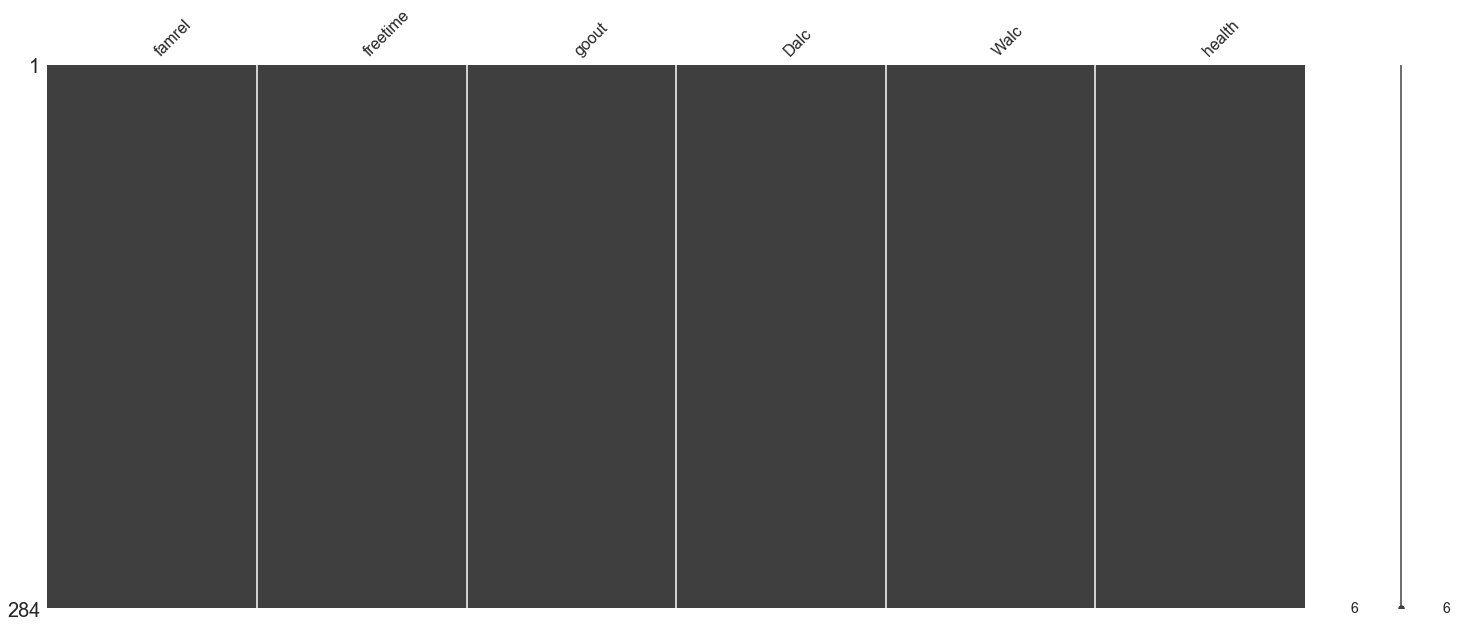

In [38]:
tmp = tmp.dropna()
trust_df = tmp.loc[:, 'famrel':'health']
msno.matrix(trust_df)

In [39]:
famrel_df = quest_batery(trust_df, "famrel")
freetime_df = quest_batery(trust_df, "freetime")
goout_df = quest_batery(trust_df, "goout")
dalc_df = quest_batery(trust_df, "Dalc")
walc_df = quest_batery(trust_df, "Walc")
health_df = quest_batery(trust_df, "health")


Text(0, 0.5, 'Pregunta')

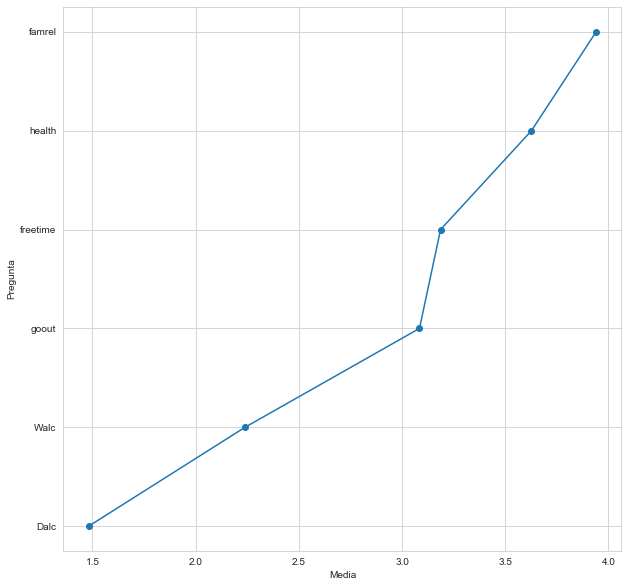

In [40]:
questions_df = pd.concat([famrel_df,
                          freetime_df,
                          goout_df,
                          dalc_df,
                          walc_df,
                          health_df])
questions_df = questions_df.sort_values(by = ["mean"])
plt.figure(figsize = (10,10))
plt.plot(questions_df["mean"], questions_df["var"], "o-")
plt.xlabel("Media")
plt.ylabel("Pregunta")

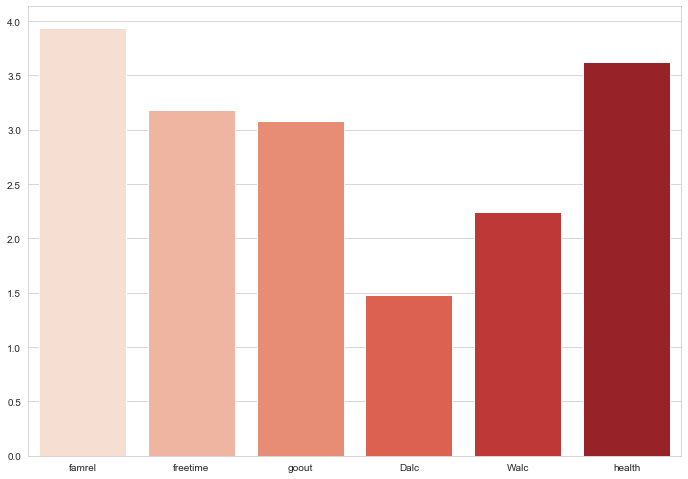

In [41]:
rcParams['figure.figsize'] = 11.7,8.27
sns.barplot(x = trust_df.mean().index, y = trust_df.mean(), palette="Reds")
plt.show()

Existe mayor confianza al momento de responder preguntas referentes a la calidad de relaciones familiares que respecto al consumo de alcohol.

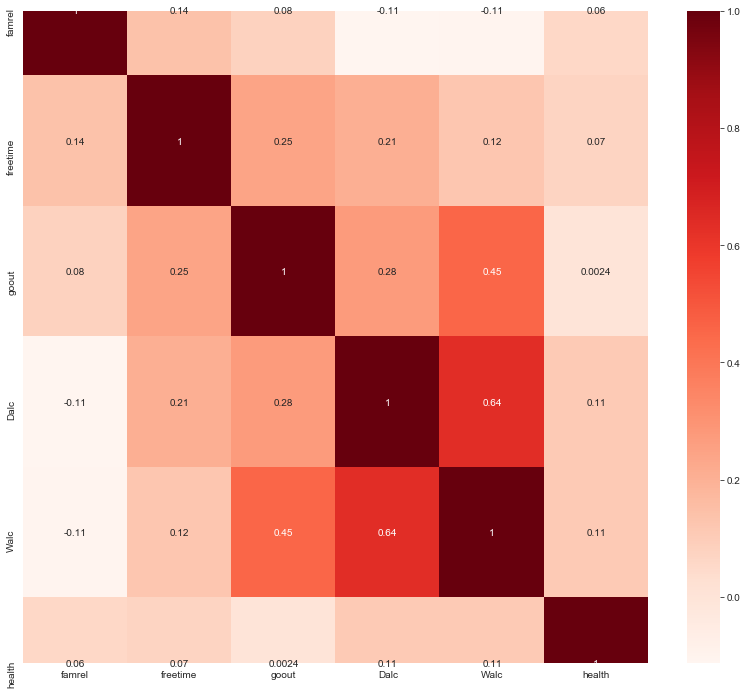

In [42]:
rcParams['figure.figsize'] = 14,12
sns.heatmap(trust_df.corr(), cmap='Reds', annot=True)

### Correlación entre atributos:
* Dalc: Beber alcohol durante los dias de semana
* Walc: Beber alcohol durante el fin de semana <br>
<b> Dalc - Walc, se correlacionan con un 64% </b>


* goout: Salidas con amigos
* Walc: Beber alcohol durante el fin de semana <br>
<b> goout - Walc, se correlacionan con un 45% </b>

### Prueba de Esferacidad de Bartlett

In [43]:
factor.calculate_bartlett_sphericity(trust_df)[1]

1.0103392888965118e-46

#### $H_0$ -> La matriz de correlaciones es una matriz de identidad.

#### El segundo elemento de la lista es $1.0e^{-46}$ , este valor es menor a 0.05, se falla en rechazar la hipotesis nula.

### Prueba Kaiser-Meyer-Olkin
KMO > 0.7 -> Existe por lo menos un factor latente

KMO < 0.7 -> No existen factores latentes

In [44]:
factor.calculate_kmo(trust_df)

(               KMO
 famrel    0.503497
 freetime  0.578644
 goout     0.618506
 Dalc      0.588351
 Walc      0.557151
 health    0.594361, 0.5784452766434517)

KMO GLOBAL >.7

### Dado un KMO global de 0.57, que es menor a .7, se determina que no existen factores latentes.

* desconozco si apesar de no existir factores se debe calcular de igual manera (para la prueba), dejo el desarrollo del código en base a lo realizado en clases.

In [45]:
factorize = factor.FactorAnalyzer()
factorize.analyze(trust_df, n_factors =6, rotation = "varimax")
factor_eigenvalues = factorize.get_eigenvalues()[0]

IndexError: tuple index out of range

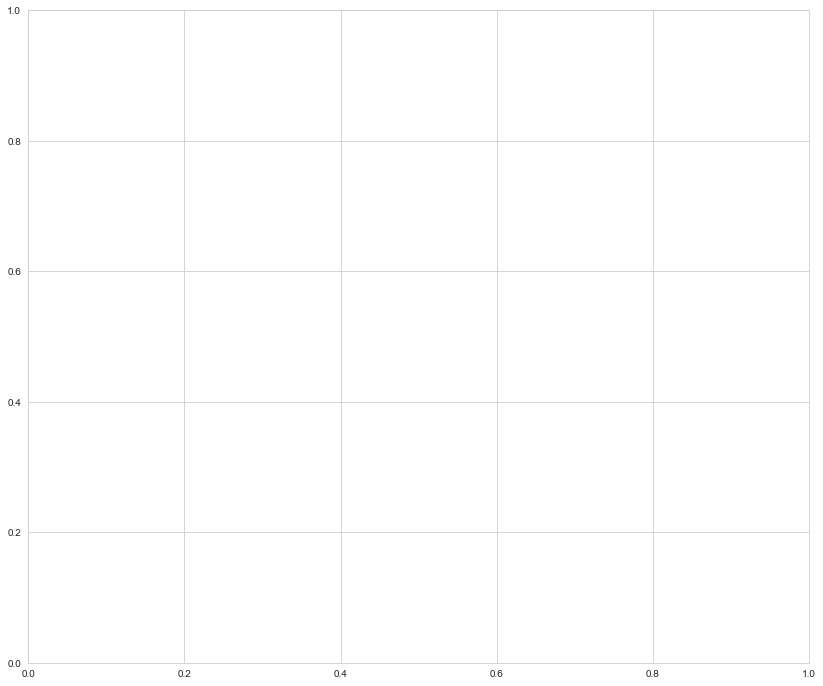

In [46]:
plt.plot(factor_eigenvalues.index + 1,
        factor_eigenvalues.values, "o-", color = "tomato")
plt.xlabel("Numero de factores latentes")
plt.ylabel("Eigenvalues")
plt.axhline(1)

#### Dado que existen 2 valores sobre el 1, se decide conversar 2 factores latentes.

In [ ]:
factorize = factor.FactorAnalyzer()
factorize.analyze(trust_df, n_factors = 2, rotation = "varimax")

In [ ]:
factorize.loadings.applymap(lambda x: np.where(x < .4, " ", round(x, 2)))

In [ ]:
extract_factor_scores = factorize.get_scores(trust_df)

In [ ]:
dffactor = df.copy()
dffactor["Factor1"] = extract_factor_scores["Factor1"]
dffactor["Factor2"] = extract_factor_scores["Factor2"]

### Regresión Lineal para medir factores en relación a los atributos del df

In [ ]:
columnas = df.columns.to_list()
tmpcolumns = 'Factor1 ~ '
for columna in columnas:
    if columna  not in ['G3','G2','G1']:
        tmpcolumns += ' + '+ columna
tmpcolumns

In [ ]:
modelo_factor1 = smf.ols(tmpcolumns, dffactor).fit()

In [ ]:
coefplot(modelo_factor1)

#### atributos significantes para factor1
+ bin_absences_24
+ bin_absences_22
+ bin_absences_54
+ bin_absences_14
+ bin_absences_6
+ bin_absences_4
+ bin_goout_1
+ bin_goout_4
+ bin_famrel_2
+ bim_famrel_3
+ bim_nursery_no
+ bin_paid_yes
+ bin_traveltime_3
+ bin_guardan_other
+ bin_reason_reputation
+ bin_fjob_health
+ bin_fjob_teacher
+ bin_Mjob_at_home
+ bin_age_19
+ bin_sex_m

In [ ]:
columnas = df.columns.to_list()
tmpcolumns = 'Factor2 ~ '
for columna in columnas:
    if columna  not in ['G3','G2','G1']:
        tmpcolumns += ' + '+ columna
tmpcolumns

In [ ]:
modelo_factor2 = smf.ols(tmpcolumns, dffactor).fit()

In [ ]:
coefplot(modelo_factor2)

#### Atriburos relevantes para el factor 2
+ bin_absences_26
+ bin_absences_22
+ bin_absences_15
+ bin_absences_12
+ bin_walc_3
+ bin_internet_no
+ bin_higher_no
+ bin_failures_2
+ bin_mjob_health
+ bin_mjob_teacher
+ bin_mjob_services
+ bin_fedu_1 